In [1]:
# Import basic libraries needed for the exercise (numpy, matplotlib, and torch)
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils import data
from torch.autograd import Variable
import torch.nn.functional as F

# Decoy MNIST Lab

In this lab, we'll introduce some basic concepts in interpretable machine learning through a short series of exerises on the "Decoy MNIST" dataset from [this paper](https://arxiv.org/pdf/1703.03717.pdf).

## Load and visualize the dataset:

In [2]:
# Load the Decoy MNIST dataset
cached = np.load('./decoy-mnist.npz')
arrays = [cached[f] for f in sorted(cached.files)]
X_train, y_train, X_val, y_val, X_test, y_test = arrays

# Verify we get 50000/10000/10000 x 784
print(X_train.shape, X_val.shape, X_test.shape)

(50000, 784) (10000, 784) (10000, 784)


Decoy MNIST is a version of the [MNIST handwritten digit dataset](http://yann.lecun.com/exdb/mnist/) that has been modified to include a special color swatch in a random corner of the image. In the training (n=50000) and validation (n=10000) sets, the shade of this color swatch corresponds exactly to the digit label, while in the test set, the shade is chosen randomly:

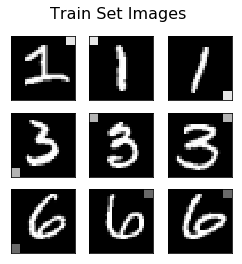

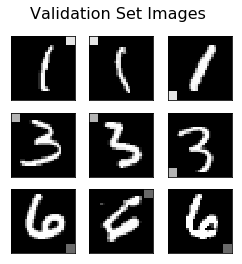

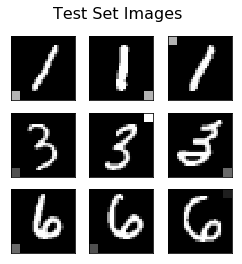

In [3]:
# Plot some examples from the training / validation / test sets:

def random_digits_matching(digit, X, y):
    idx = np.argwhere(y == digit)[:,0]
    np.random.shuffle(idx)
    return X[idx]
  
def plot_digit(x):
    """Plot 2D image in black and white."""
    lim = np.abs(x).max()
    plt.imshow(x.reshape(-28,28), cmap='gray')
    plt.xticks([])
    plt.yticks([])

for split, X, y in [('Train', X_train, y_train), ('Validation', X_val, y_val), ('Test', X_test, y_test)]:
    fig = plt.figure(figsize=(4,4))
    fig.suptitle(split + " Set Images", fontsize=16)
    plot = 0
    for digit in [1, 3, 6]:
        images = random_digits_matching(digit, X, y)
        for i in range(3):
            plot += 1
            plt.subplot(3,3,plot)
            plot_digit(images[i])
    plt.show()

By adding this color swatch, we've deliberately introduced what can either be seen as a _redundancy_ (in that we have two conceptually independent ways of predicting the label during training) or an _incompleteness_ (in that the training images and labels now actually provide us **less** information about the right function to learn).

We'll explore the consequences of this redundancy / incompleteness below.

## Define neural network class

To test out how models react to redundancy, we first need to define at least one type of model. For this lab, we'll focus on a relatively simple 784x50x50x10 fully-connected neural network (to minimize training time).

In [4]:
def one_hot(y):
    """Convert Nx1 flat list of digits to Nx10 'one-hot' encoded array."""
    values = np.arange(10)
    return np.array([values == v for v in y]).astype(int)
  
class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        """Initialize a 2-hidden-layer fully connected neural network w/ ReLU activations."""
        super(SimpleNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(784, 50) 
        self.fc2 = nn.Linear(50, 50)  
        self.fc3 = nn.Linear(50, 10)  
        self.relu = nn.ReLU()
    
    def forward(self, x):
        """Forward pass of the neural network, mapping input tensors -> unnormalized digit logits."""
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out
      
    def predict(self, x):
        """Map numpy input images to digit predictions"""
        images = torch.Tensor(x)
        logits = self(images)
        return np.argmax(logits.data.numpy(), axis=1)
      
    def accuracy(self, x, y):
        """Compute accuracy of predictions."""
        return (self.predict(x) == y).mean()
      
    def input_grads(self, x):
        """Map numpy input images to saliency maps (as log-probability input gradients)"""
        images = Variable(torch.Tensor(x), requires_grad=True)
        logits = self(images) # pass images through the network
        logprobs = F.log_softmax(logits, 1) # compute log-probs for each digit
        logprobs.sum().backward() # sum log-probs to get a scalar quantity dependent on all outputs
        return images.grad.data.numpy() # return the input gradient
      
    def fit(self, X, y, lr=0.001, weight_decay=0.01, epochs=None, batch_size=256):
        """Fit the neural network on inputs `X` and labels `y`
        for `epochs` passes through the dataset in `batch_size` increments
        with `lr` learning rate and the provided L2 `weight_decay`."""
        
        # Train for about 2000 steps, by default
        if epochs is None:
          epochs = (2000 * batch_size) // len(X)
          
        # Use cross-entropy + weight decay loss and Adam
        loss_func = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        
        # Convert numpy dataset to tensors
        dataset = data.TensorDataset(torch.Tensor(X), torch.Tensor(one_hot(y)))
        loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        # Main training loop
        for epoch in range(epochs):
            for images, labels in loader:
                optimizer.zero_grad()
                outputs = self(Variable(images))
                loss = loss_func(outputs, Variable(labels))
                loss.backward()
                optimizer.step()
            print('Epoch {}, Loss: {:.4f}'.format(epoch+1, loss.data))         

## Train network on training data

Let's fit our model on the data (using a relatively high weight decay):

In [5]:
net = SimpleNeuralNetwork()
net.fit(X_train, y_train, lr=0.001, weight_decay=0.01)

Epoch 1, Loss: 0.0298
Epoch 2, Loss: 0.0182
Epoch 3, Loss: 0.0270
Epoch 4, Loss: 0.0134
Epoch 5, Loss: 0.0176
Epoch 6, Loss: 0.0194
Epoch 7, Loss: 0.0190
Epoch 8, Loss: 0.0142
Epoch 9, Loss: 0.0207
Epoch 10, Loss: 0.0078


## Examine validation and test accuracy

Now that we've fit our model, we can look at its accuracy:

In [6]:
print("Validation accuracy:", net.accuracy(X_val, y_val))

Validation accuracy: 0.9781


In [7]:
print("Test accuracy:", net.accuracy(X_test, y_test))

Test accuracy: 0.723


You should notice that test accuracy, while still well above random guessing, is significantly lower than validation accuracy.

This is likely because the testing dataset contains two conflicting rules: the digit image and the color swatch. The fact that test accuracy is (likely) closer to 1 than 1/10 suggests the model is more reliant on the digit image than the color swatch, but it's still clearly confused.

Let's try to investigate what's going on using a saliency method:

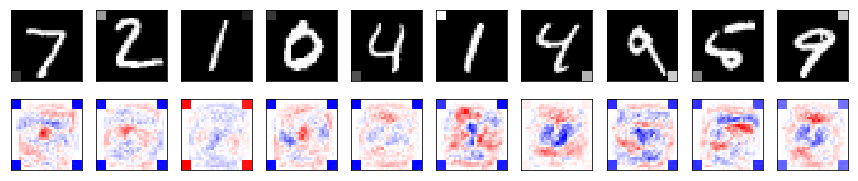

In [8]:
# Compute input gradients, a basic saliency method
# (we'll cover this in the next section in more detail)
grads = net.input_grads(X_test)

# Plot them as heatmaps 
def plot_grad(x):
    """Plot gradient as heatmap, where red = positive, blue = negative, and white = 0."""
    lim = np.abs(x).max()
    plt.imshow(x.reshape(-28,28), cmap='bwr', vmin=-lim, vmax=lim)
    plt.xticks([])
    plt.yticks([])

plt.figure(figsize=(15,3))
for i in range(10):
  plt.subplot(2,10,i+1)
  plot_digit(X_test[i])
for i in range(10):
  plt.subplot(2,10,i+11)
  plot_grad(grads[i])

These plots highlight areas where the model is locally sensitive to small changes (fuller explanation below).

**The main takeaway here is that the model's outputs are very sensitive both to changes in the corner pixels and to changes in the main digit region, suggesting a reasonable dependence on both.**

<small>
If you're curious about how to understand _exactly_ what these plots mean, you're not the only one -- saliency maps are notorious for being difficult to interpret, and we'll cover these issues in later classes. However, for completeness, here's what these plots literally mean:
- whitening the image at red areas increases the model's confidence in its prediction
- whitening the image at blue areas decreases the model's confidence in its prediction
- the degree of redness or blueness quantifies the magnitude of this increase or decrease
</small>
 

# Exercises for you

## Exercise 1: Create a second neural network, except this time, `fit` it on `X_test` / `y_test` and then evaluate its performance / visualize its gradients on the training or validation set

In [9]:
# Initialize and fit network
net2 = SimpleNeuralNetwork()
net2.fit(X_test, y_test, lr=0.001, weight_decay=0.01)

Epoch 1, Loss: 0.1477
Epoch 2, Loss: 0.1380
Epoch 3, Loss: 0.0228
Epoch 4, Loss: 0.0301
Epoch 5, Loss: 0.1066
Epoch 6, Loss: 0.0531
Epoch 7, Loss: 0.0426
Epoch 8, Loss: 0.0761
Epoch 9, Loss: 0.0433
Epoch 10, Loss: 0.0259
Epoch 11, Loss: 0.0267
Epoch 12, Loss: 0.0296
Epoch 13, Loss: 0.0147
Epoch 14, Loss: 0.0536
Epoch 15, Loss: 0.0205
Epoch 16, Loss: 0.0164
Epoch 17, Loss: 0.0171
Epoch 18, Loss: 0.0229
Epoch 19, Loss: 0.0043
Epoch 20, Loss: 0.0206
Epoch 21, Loss: 0.0508
Epoch 22, Loss: 0.0132
Epoch 23, Loss: 0.0557
Epoch 24, Loss: 0.0433
Epoch 25, Loss: 0.0190
Epoch 26, Loss: 0.0019
Epoch 27, Loss: 0.0176
Epoch 28, Loss: 0.0173
Epoch 29, Loss: 0.0315
Epoch 30, Loss: 0.0058
Epoch 31, Loss: 0.0246
Epoch 32, Loss: 0.0458
Epoch 33, Loss: 0.0220
Epoch 34, Loss: 0.0109
Epoch 35, Loss: 0.0188
Epoch 36, Loss: 0.0165
Epoch 37, Loss: 0.0103
Epoch 38, Loss: 0.0473
Epoch 39, Loss: 0.0762
Epoch 40, Loss: 0.0067
Epoch 41, Loss: 0.0066
Epoch 42, Loss: 0.0085
Epoch 43, Loss: 0.0025
Epoch 44, Loss: 0.00

In [12]:
# Compute accuracies
print("Validation accuracy:", net2.accuracy(X_val, y_val))
print("Train (test?) accuracy:", net2.accuracy(X_train, y_train))

Validation accuracy: 0.9427
Train (test?) accuracy: 0.9453


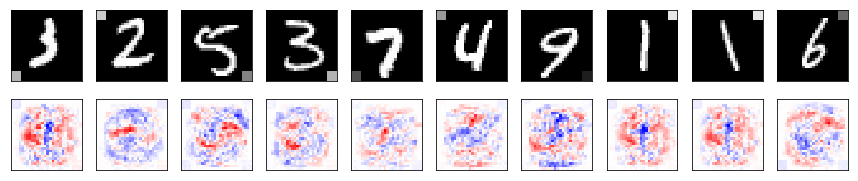

In [13]:
# Plot saliencies

grads = net2.input_grads(X_val)

plt.figure(figsize=(15,3))
for i in range(10):
  plt.subplot(2,10,i+1)
  plot_digit(X_val[i])
for i in range(10):
  plt.subplot(2,10,i+11)
  plot_grad(grads[i])

Can you see any difference in behavior between this new model and the net you fit on the original training set, either in its accuracy statistics or its saliency maps? What to these quantitative values (accuracy + gradients) tell you about its qualitative differences?

## Exercise 2: Explore the effect of weight decay at `0.0`, `0.0001`, `0.01`, `0.1`, and `1.0`

In our `fit` method, we pass in `weight_decay` value of `0.01`. This means that during training, we're minimizing not just the cross-entropy loss (i.e. prediction error), but also the complexity of our model --- as quantifiied by `0.01` times the sum of the squares of its weights.

In this example, we'd like you to test out the effect of the weight decay on the model's sensitivity to the color swatch and on its saliency maps.

In [15]:
weight_decays = [0.0, 0.0001, 0.01, 0.1, 1.0]

In [16]:
# Fit models for each weight decay value

nets = {}
for wd in weight_decays:
  net = SimpleNeuralNetwork()
  net.fit(X_train, y_train, weight_decay=wd)
  nets[wd] = net

Epoch 1, Loss: 0.0275
Epoch 2, Loss: 0.0437
Epoch 3, Loss: 0.0256
Epoch 4, Loss: 0.0056
Epoch 5, Loss: 0.0101
Epoch 6, Loss: 0.0151
Epoch 7, Loss: 0.0066
Epoch 8, Loss: 0.0228
Epoch 9, Loss: 0.0053
Epoch 10, Loss: 0.0047
Epoch 1, Loss: 0.0539
Epoch 2, Loss: 0.0283
Epoch 3, Loss: 0.0273
Epoch 4, Loss: 0.0224
Epoch 5, Loss: 0.0153
Epoch 6, Loss: 0.0094
Epoch 7, Loss: 0.0224
Epoch 8, Loss: 0.0108
Epoch 9, Loss: 0.0124
Epoch 10, Loss: 0.0042
Epoch 1, Loss: 0.0191
Epoch 2, Loss: 0.0277
Epoch 3, Loss: 0.0178
Epoch 4, Loss: 0.0182
Epoch 5, Loss: 0.0266
Epoch 6, Loss: 0.0098
Epoch 7, Loss: 0.0226
Epoch 8, Loss: 0.0096
Epoch 9, Loss: 0.0147
Epoch 10, Loss: 0.0411
Epoch 1, Loss: 0.0564
Epoch 2, Loss: 0.0606
Epoch 3, Loss: 0.0614
Epoch 4, Loss: 0.0548
Epoch 5, Loss: 0.0534
Epoch 6, Loss: 0.0477
Epoch 7, Loss: 0.0444
Epoch 8, Loss: 0.0417
Epoch 9, Loss: 0.0547
Epoch 10, Loss: 0.0566
Epoch 1, Loss: 0.2348
Epoch 2, Loss: 0.2828
Epoch 3, Loss: 0.2926
Epoch 4, Loss: 0.2870
Epoch 5, Loss: 0.2950
Epoch 

In [18]:
# Print all of their validation and test accuracies
print('Weight decay, validation accuracy, test accuracy')
for wd in weight_decays:
  print('{:.4f}'.format(wd), nets[wd].accuracy(X_val, y_val), nets[wd].accuracy(X_test, y_test))

Weight decay, validation accuracy, test accuracy
0.0000 0.9765 0.6316
0.0001 0.9769 0.6289
0.0100 0.9726 0.7165
0.1000 0.9438 0.7644
1.0000 0.3959 0.3897


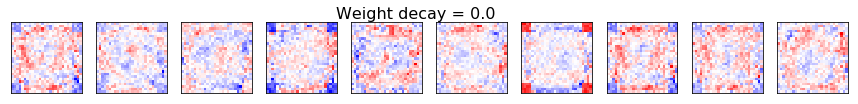

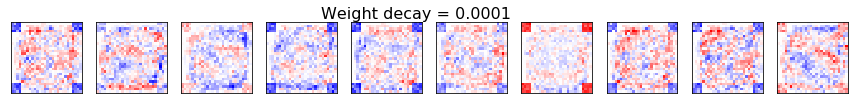

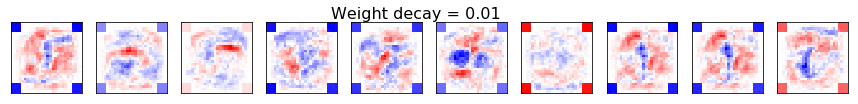

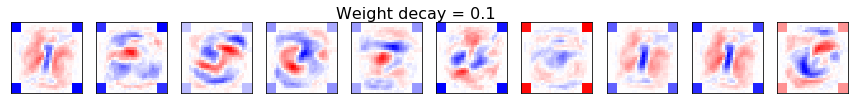

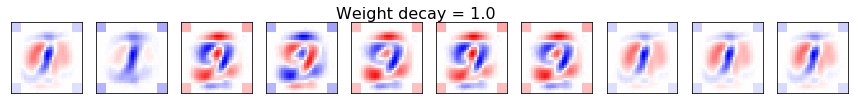

In [19]:
# Plot each model's input gradients for the first 10 test examples

for wd in weight_decays:
  grads = nets[wd].input_grads(X_val)
  fig = plt.figure(figsize=(15,1.5))
  fig.suptitle('Weight decay = {}'.format(wd), fontsize=16)
  for i in range(10):
    plt.subplot(1,10,i+1)
    plot_grad(grads[i])

What do you notice about the different models? Does the gap between validation and test accuracy change as a function of weight decay? Does the validation accuracy of the model change? How about the smoothness of the saliency maps?  What, if anything, do you feel you can _interpret_ about the differences between each of the models?